<a href="https://colab.research.google.com/github/Vaggelis-Arg/Amazon-Ecommerce-Analysis/blob/main/Amazon_Ecommerce_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining (2024-2025)

### Team Information

#### Team member #1: [**Vaggelis-Arg**](https://github.com/Vaggelis-Arg)
* Name: Evangelos Argyropoulos
* ID: sdi2200010
* Email: sdi2200010@di.uoa.gr
---
#### Team member #2: [**chrisvl11**](https://github.com/chrisvl11)
* Name: Christos Vladikas
* ID: sdi2200020
* Email: sdi2200020@di.uoa.gr
---
#### Team member #3: [**tonykalantzis**](https://github.com/tonykalantzis)
* Name: Antonios Panagiotis Kalatzis
* ID: sdi2100046
* Email: sdi2100046@di.uoa.gr
---

## Set up of the notebook

### Downloads

In [1]:
!pip install nltk transformers torch contractions matplotlib seaborn wordcloud hf_xet scikit-learn
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing 

### Remove any leftover datasets from previous runs

In [2]:
!rm -f *.csv

### Imports

In [3]:
import nltk
nltk.download(['punkt', 'stopwords', 'vader_lexicon', 'wordnet','omw-1.4', 'punkt_tab'])
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datasets import load_dataset
import pandas as pd
import re
import string
import random
import contractions
from nltk.corpus import stopwords
from datasets import load_dataset
from matplotlib.gridspec import GridSpec
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.sparse import hstack
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
from scipy import spatial
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB, CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import torch
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
2025-06-19 14:59:57.964006: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750345198.139031      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: A

## Part 1 - Pre-processing

### Task 1: Data Exploration and Feature Engineering

#### Dataset Preparation

We used the `datasets` library from Hugging Face to stream and extract reviews and metadata for selected Amazon product categories.

The dataset includes product reviews, ratings, and associated metadata. After loading, the data was saved as CSV files (`*_reviews_raw.csv` and `*_metadata_raw.csv`) to simplify further processing.

We ensure the CSVs contain essential fields like `rating`, `text`, `parent_asin`, and product details for later analysis.



In [4]:
# Configs: (category_name, review_config, meta_config)
datasets_info = [
    ("Books", "raw_review_Books", "raw_meta_Books"),
    # ("All_Beauty", "raw_review_All_Beauty", "raw_meta_All_Beauty"),
    # ("Electronics", "raw_review_Electronics", "raw_meta_Electronics"),
    # ("Movies_and_TV", "raw_review_Movies_and_TV", "raw_meta_Movies_and_TV"),
    # ("Sports_and_Outdoors", "raw_review_Sports_and_Outdoors", "raw_meta_Sports_and_Outdoors"),
]

# Select correct columns
review_columns = [
    "rating", "title", "text", "parent_asin", "asin" , "user_id", "timestamp",
    "helpful_vote", "verified_purchase"
]
meta_columns = [
    "parent_asin", "main_category", "title", "average_rating", "rating_number",
    "description", "price", "categories", "bought_together", "store"
]

for category, review_config, metadata_config in datasets_info:
    print(f"Loading: {category}")

    # Load streaming datasets with limited columns
    reviews_iter = load_dataset(
        "McAuley-Lab/Amazon-Reviews-2023",
        review_config,
        split="full",
        streaming=True,
        trust_remote_code=True
    ).select_columns(review_columns)

    metadata_iter = load_dataset(
        "McAuley-Lab/Amazon-Reviews-2023",
        metadata_config,
        split="full",
        streaming=True,
        trust_remote_code=True
    ).select_columns(meta_columns)

    # Convert to pandas and save
    reviews_df = pd.DataFrame(reviews_iter.take(100_000))
    metadata_df = pd.DataFrame(metadata_iter.take(100_000))

    reviews_df.to_csv(f"{category}_reviews.csv", index=False)
    metadata_df.to_csv(f"{category}_metadata.csv", index=False)

    print(f"Saved selected columns for {category}")


Loading: Books


README.md:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

Amazon-Reviews-2023.py:   0%|          | 0.00/39.6k [00:00<?, ?B/s]

HTTP Error 504 thrown while requesting GET https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/resolve/2b6d039ed471f2ba5fd2acb718bf33b0a7e5598e/raw/meta_categories/meta_Books.jsonl
Retrying in 1s [Retry 1/5].


Saved selected columns for Books


#### Text Preprocessing

Text fields like `title` and `review text` were cleaned using a custom preprocessing function that includes:

- Lowercasing
- URL, mention, hashtag, and email removal
- Contraction expansion (`don't` → `do not`)
- Emoticon normalization (e.g., `:)` → `happy`)
- Removal of punctuation, numbers, and excessive character repetitions
- Lemmatization (reducing words to their base or dictionary form, e.g., running → run)

These cleaned fields (`cleaned_title`, `cleaned_text`) are used for visualizations and later analysis tasks.


In [5]:
# Emoticon dictionary for replacements
emoticons = {
    ":)": "happy", ":D": "very happy", ":-)": "happy", "(:": "happy",
    ";)": "winking", ";-)": "winking", "(:": "happy", "^^": "happy",
    ":(": "sad", ":-(": "sad", "):": "sad",
    ":o": "surprised", ":-o": "surprised", ":O": "shocked",
    ":'(": "crying", ":-'(": "crying",
    ":P": "playful", ":-P": "playful", ";P": "cheeky", ";-P": "cheeky",
    "<3": "love", "</3": "heartbroken"
}

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def normalize_price(price, min_price, max_price):
    return (price - min_price) / (max_price - min_price) if max_price != min_price else 0

# Preprocessing function
def preprocess_text(text):
    if pd.isna(text):
        return ""

    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", 'link', text)  # replace URLs
    text = re.sub(r"\@\w+|\#\w+", 'tag', text)  # replace mentions and hashtags
    text = re.sub(r"\S+@\S+", 'mail', text)  # replace emails
    text = re.sub(r'\d+', 'number', text) # replace numbers
    text = contractions.fix(text)  # expand contractions

    # Replace emoticons
    for emoticon, word in emoticons.items():
        text = text.replace(emoticon, word)

    text = re.sub(r"[" + string.punctuation + "]", '', text)  # remove punctuation
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)  # reduce 3+ char repeats to 2
    
    # Tokenize and Lemmatize
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    text = ' '.join(tokens)
    return text

# Load and clean each dataset
for category, *_ in datasets_info:
    print(f"Preprocessing: {category}")
    reviews = pd.read_csv(f"{category}_reviews.csv")
    metadata = pd.read_csv(f"{category}_metadata.csv")

    reviews = reviews.dropna(subset=["rating", "text", "parent_asin"])

    # preprocess text fields
    reviews["cleaned_title"] = reviews["title"].apply(preprocess_text)
    reviews["cleaned_text"] = reviews["text"].apply(preprocess_text)
    reviews["timestamp"] = pd.to_datetime(reviews["timestamp"], unit="ms")

    metadata["cleaned_title_meta"] = metadata["title"].apply(preprocess_text)
    metadata["cleaned_description"] = metadata["description"].apply(preprocess_text)

    df = pd.merge(reviews, metadata, on="parent_asin", how="left", suffixes=("", "_meta"))

    # normalize price
    if 'price' in df.columns:
        df['price'] = pd.to_numeric(df['price'], errors='coerce')

        # Remove any rows where price is NaN
        df = df.dropna(subset=['price'])

        min_price = df['price'].min()
        max_price = df['price'].max()
        df['normalized_price'] = df['price'].apply(lambda x: normalize_price(x, min_price, max_price))

    df.to_csv(f"{category}_cleaned.csv", index=False)
    print(f"Saved cleaned data to {category}_cleaned.csv")

print(reviews.head())

Preprocessing: Books
Saved cleaned data to Books_cleaned.csv
   rating                                              title  \
0     1.0      Not a watercolor book! Seems like copies imo.   
1     5.0  Updated: after 1st arrived damaged this one is...   
2     5.0                              Excellent! I love it!   
3     5.0       Updated after 1st arrived damaged. Excellent   
4     5.0                                Beautiful patterns!   

                                                text parent_asin        asin  \
0  It is definitely not a watercolor book.  The p...  B09BGPFTDB  B09BGPFTDB   
1  Updated: after first book arrived very damaged...  0593235657  0593235657   
2  I bought it for the bag on the front so it pai...  1782490671  1782490671   
3  Updated: after 1st arrived damaged the replace...  0593138228  0593138228   
4  I love this book!  The patterns are lovely. I ...  0823098079  0823098079   

                        user_id               timestamp  helpful_vote  \


#### Ratings and Reviews

We performed exploratory data analysis on the cleaned dataset, including:

##### 1. Rating Distribution

We plotted a histogram to show how product ratings are distributed across all reviews in each category.

##### 2. Low-Rated Popular Products – Word Cloud

We identified products with an average rating below 3 and a sufficient number of reviews, then generated a word cloud from their review texts to highlight frequently used negative terms.

##### 3. Rating Trends Over Time

We computed the average rating per month and plotted a line chart to observe how customer sentiment evolves over time. This helps detect seasonality or significant shifts in perception.

##### 4. Top 5 Best-Selling Products

We listed the five most-reviewed products in each category, including:
- Title
- ASIN
- Store (if available)
- Average rating
- Total number of reviews

Visualizing: Books


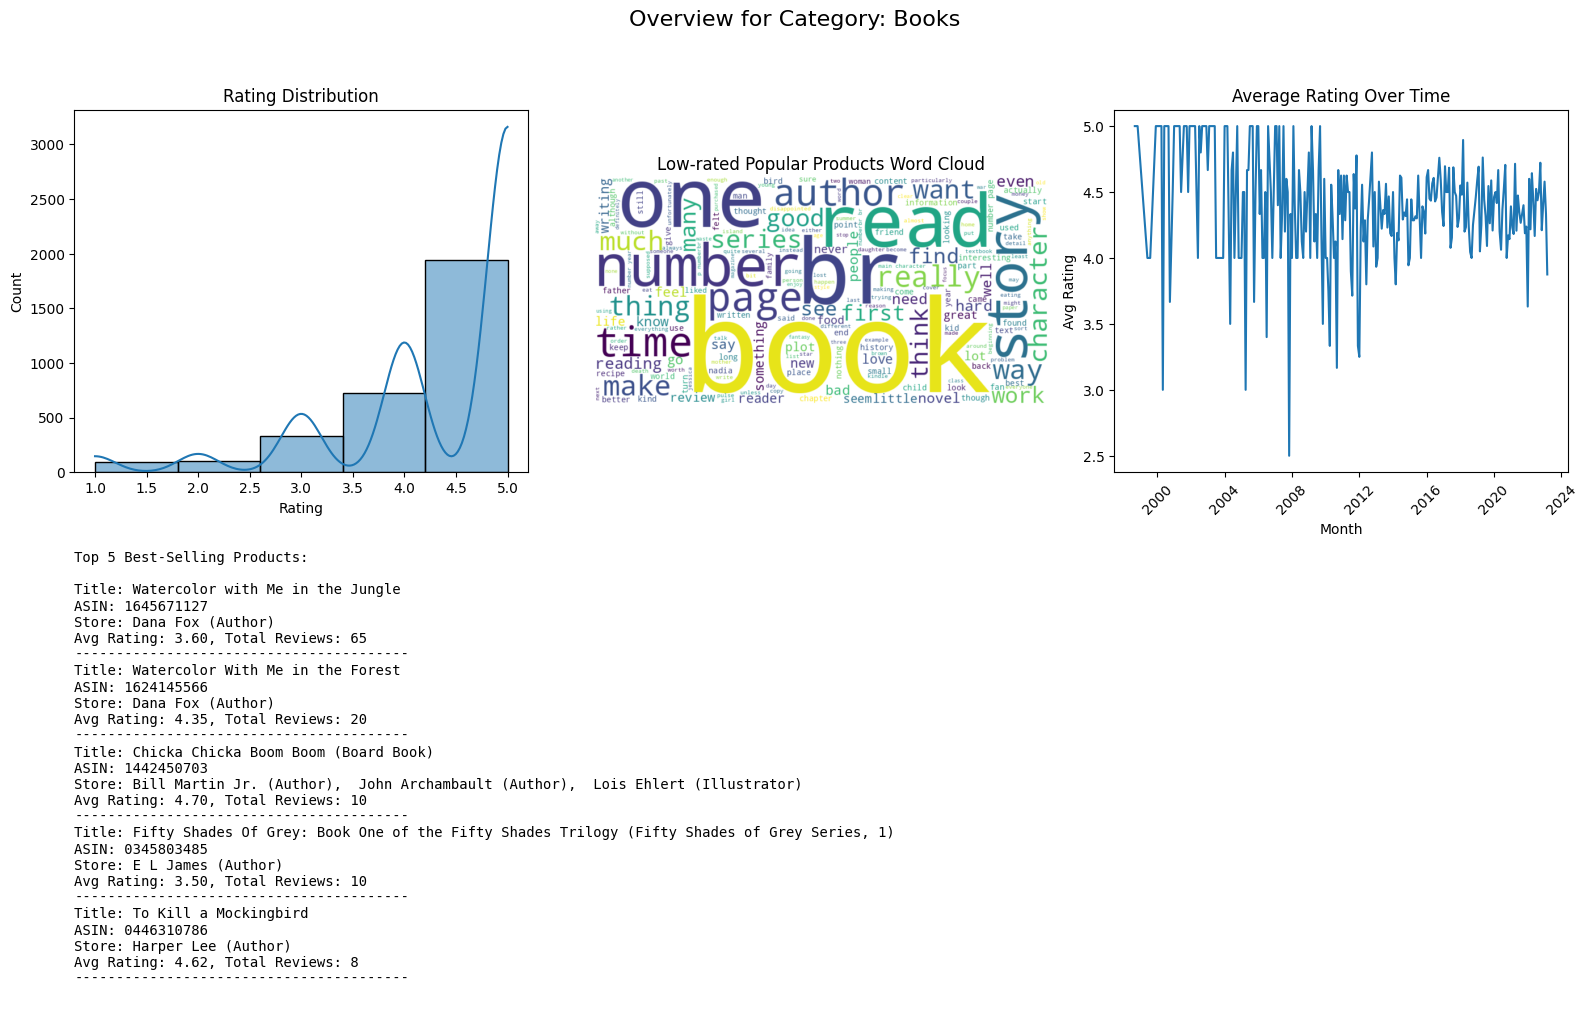

In [6]:
for category, *_ in datasets_info:
    print(f"Visualizing: {category}")
    df = pd.read_csv(f"{category}_cleaned.csv")
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df["month"] = df["timestamp"].dt.to_period("M").dt.to_timestamp()

    df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
    df = df.dropna(subset=["rating"])

    stats = df.groupby("parent_asin").agg(
        avg_rating=("rating", "mean"),
		count=("rating", "count")
	).reset_index()

    bad_asins = stats[
    	(stats["count"] >= 0) & (stats["avg_rating"] < 3)
	]["parent_asin"]

    bad_text = " ".join(df[df["parent_asin"].isin(bad_asins)]["cleaned_text"].dropna())
    wordcloud = None
    if bad_text.strip():
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(bad_text)

    # Prepare trend data
    trend = df.groupby("month")["rating"].mean().reset_index()

    # Prepare top products text
    top5 = df["parent_asin"].value_counts().head(5).index
    top_products_info = ""
    for asin in top5:
        item = df[df["parent_asin"] == asin].iloc[0]
        avg_rating = df[df["parent_asin"] == asin]["rating"].mean()
        total_reviews = len(df[df["parent_asin"] == asin])
        top_products_info += (
            f"Title: {item.get('title_meta', 'N/A')}\n"
            f"ASIN: {asin}\n"
            f"Store: {item.get('store', 'Unknown')}\n"
            f"Avg Rating: {avg_rating:.2f}, Total Reviews: {total_reviews}\n"
            f"{'-'*40}\n"
        )

    # Create subplots
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle(f"Overview for Category: {category}", fontsize=16, y=1.02)
    gs = GridSpec(2, 3, figure=fig)

    # Histogram
    ax1 = fig.add_subplot(gs[0, 0])
    sns.histplot(df["rating"], bins=5, kde=True, ax=ax1)
    ax1.set_title("Rating Distribution")
    ax1.set_xlabel("Rating")
    ax1.set_ylabel("Count")

    # Word Cloud
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_title("Low-rated Popular Products Word Cloud")
    if wordcloud:
        ax2.imshow(wordcloud, interpolation="bilinear")
        ax2.axis("off")
    else:
        ax2.text(0.5, 0.5, "No data for word cloud", ha='center', va='center', fontsize=12)
        ax2.axis("off")

    # Trend Line
    ax3 = fig.add_subplot(gs[0, 2])
    sns.lineplot(data=trend, x="month", y="rating", ax=ax3)
    ax3.set_title("Average Rating Over Time")
    ax3.set_xlabel("Month")
    ax3.set_ylabel("Avg Rating")
    ax3.tick_params(axis='x', rotation=45)

    # Text Box for Top Products
    ax4 = fig.add_subplot(gs[1, :])
    ax4.axis("off")
    ax4.text(0, 1, f"Top 5 Best-Selling Products:\n\n{top_products_info}", ha='left', va='top', fontsize=10, family='monospace')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()


### Task 2: Feature Engineering with Sentiment Scores and Ratings

#### SentimentScoreWithRating Class

This class combines the **text sentiment** of a review with its **numeric rating (1–5)** to generate a more informative sentiment score.

---

#### 1. Sentiment Extraction

- Uses either **VADER** or a **Hugging Face model** (`DistilBERT`, `RoBERTa`, or `BERT`)
- Converts review text to a sentiment score in the range:

$$
\text{sentiment\_score} \in [-1, 1]
$$

---

#### 2. Weighted Sentiment + Rating

To balance sentiment from text and numeric rating:

$$
\text{final\_score} = w_1 \cdot \text{sentiment\_score} + w_2 \cdot \text{normalized\_rating}
$$

where:

$$
\text{normalized\_rating} = \frac{\text{rating} - 1}{4}
$$

Default weights: \( w_1 = 0.5 \), \( w_2 = 0.5 \)

---

#### 3. Rating-Adjusted Sentiment

Boost or reduce sentiment depending on how strong the rating is:

- Add adjustment (e.g. +0.2) if rating is 4 or 5  
- Subtract adjustment (e.g. -0.2) if rating is 1 or 2

This ensures the final score reflects both tone and user satisfaction.

---

In [7]:
class SentimentScoreWithRating:
    def __init__(self, method="vader"):
        """
        method: "vader" or one of ["distilbert", "roberta", "bert"]
        """
        self.method = method.lower()
        if self.method == "vader":
            self.analyzer = SentimentIntensityAnalyzer()
        elif self.method in ["distilbert", "roberta", "bert"]:
            model_map = {
                "distilbert": "distilbert-base-uncased-finetuned-sst-2-english",
                "roberta": "cardiffnlp/twitter-roberta-base-sentiment",
                "bert": "nlptown/bert-base-multilingual-uncased-sentiment"
            }
            self.analyzer = pipeline("sentiment-analysis", model=model_map[self.method])
        else:
            raise ValueError("Unsupported method")

    def extract_sentiment_score(self, text):
        """
        Returns a sentiment score in range [-1, +1]
        """
        if self.method == "vader":
            score = self.analyzer.polarity_scores(text)["compound"]
            return score
        else:
            result = self.analyzer(text[:512])[0]
            label = result["label"]

            if self.method == "distilbert":
                return 1.0 if "positive" in label.lower() else -1.0

            elif self.method == "roberta":
                # LABEL_0 = negative, LABEL_1 = neutral, LABEL_2 = positive
                if label == "LABEL_2":
                    return 1.0
                elif label == "LABEL_0":
                    return -1.0
                else:
                    return 0.0

            elif self.method == "bert":
                # label is '1 star', '2 stars', ..., '5 stars'
                stars = int(label.split()[0])
                return (stars - 3) / 2  # Maps 1→-1, 3→0, 5→+1

            else:
                raise ValueError("Unsupported method")


    def normalize_rating(self, rating):
        """
        Normalize rating from 1-5 stars to 0-1
        """
        return (rating - 1) / 4

    def sentiment_score_weighted_text_rating(self, text, rating, w_text=0.5, w_rating=0.5):
        """
        Combine text sentiment and normalized rating via weighted average
        """
        sentiment = self.extract_sentiment_score(text)
        norm_rating = self.normalize_rating(rating)
        combined_score = w_text * sentiment + w_rating * norm_rating
        return combined_score

    def sentiment_score_rating_adjusted(self, text, rating, adjustment=0.2):
        """
        Adjust sentiment based on rating intensity
        """
        sentiment = self.extract_sentiment_score(text)

        # Adjust based on rating range
        if rating >= 4:
            sentiment = min(sentiment + adjustment, 1.0)
        elif rating <= 2:
            sentiment = max(sentiment - adjustment, -1.0)
        # If rating == 3 → no adjustment

        return sentiment


### Task 3: Feature Engineering with Price Metrics

We created two new features to improve comparability between products:

---

#### 1. Weighted Rating  
To reduce the bias from products with few reviews, we used:

$$
\text{weighted\_rating} = \text{average\_rating} \times \log(\text{rating\_number} + 1)
$$

This boosts trust in ratings with more votes and penalizes small-sample anomalies.

---

#### 2. Price per Unit  
To compare products fairly across sizes (e.g., 500ml vs 250ml), we extracted quantities like `ml`, `g`, `oz`, and computed:

$$
\text{price\_per\_unit} = \frac{\text{price}}{\text{quantity}}
$$

If no quantity was found, we assumed `quantity = 1`.

In [8]:
# for category, *_ in datasets_info:
#     print(f"\nFeature Engineering for: {category}")

#     # Load the cleaned dataset
#     df = pd.read_csv(f"{category}_cleaned.csv")

#     # Ensure numeric types
#     df["average_rating"] = pd.to_numeric(df["average_rating"], errors='coerce')
#     df["rating_number"] = pd.to_numeric(df["rating_number"], errors='coerce')
#     df["price"] = pd.to_numeric(df["price"], errors='coerce')

#     # 1. Weighted Rating
#     df["weighted_rating"] = df["average_rating"] * np.log(df["rating_number"] + 1)

#     # 2. Quantity extraction and pattern tracking
#     quantity_patterns = [
# 		r"(\d+\.?\d*)\s*(?:ml|milliliter)",
# 		r"(\d+\.?\d*)\s*(?:fl\s*?oz|fluid ounce)",
# 		r"(\d+\.?\d*)\s*(?:g|gram)",
# 		r"(\d+\.?\d*)\s*(?:kg|kilogram)",
# 		r"(\d+\.?\d*)\s*(?:lb|pound)s?",
# 		r"(\d+\.?\d*)\s*(?:count|ct|pack|pk)",
# 		r"(\d+\.?\d*)\s*(?:l|liter)s?",
# 		r"(\d+\.?\d*)\s*mg",
# 		r"(\d+)\s*pieces?",
# 		r"(\d+)\s*tablets?",
# 		r"(?i)(\d+)\s*(?:count|ct|pack|pk|pc|pcs|piece|bag|bottle|bar|serving)s?\b",
# 		r"(?i)(\d+\.?\d*)\s*(?:ounce|oz)s?",
# 		r"(?i)\b(\d+)\s*per\s*(?:pack|bottle)\b",
# 		r"(?i)(\d+)\s*(?:sheets|pads|wipes)\b",
# 		r"(?i)(\d+)\s*(?:inch|in)\b",
# 	]

#     df["quantity_extracted"] = np.nan
#     df["matched_pattern"] = np.nan

#     for pattern in quantity_patterns:
#         title_match = df["title"].str.extract(pattern, expand=True)
#         desc_match = df["description"].str.extract(pattern, expand=True)

#         title_qty = pd.to_numeric(title_match[0], errors="coerce")
#         desc_qty = pd.to_numeric(desc_match[0], errors="coerce")

#         match = title_qty.combine_first(desc_qty)

#         mask = df["quantity_extracted"].isna() & match.notna()
#         df.loc[mask, "quantity_extracted"] = match[mask]
#         df.loc[mask, "matched_pattern"] = pattern

#     # Default quantity = 1 if nothing was extracted
#     df["quantity_extracted"] = df["quantity_extracted"].fillna(1)

#     # Compute price per unit
#     df["price_per_unit"] = df["price"] / df["quantity_extracted"]
#     df["price_per_unit"] = df["price_per_unit"].replace([np.inf, -np.inf], np.nan)

#     # Print sample of ALL features
#     sample_all = df[[
#         "title", "price", "average_rating", "rating_number",
#         "weighted_rating", "quantity_extracted", "price_per_unit"
#     ]].dropna().head(10)

#     print("\nSample of generalized engineered features (top 10):")
#     print(sample_all.to_string(index=False))


## Part 2 - Learning Tasks

### Clustering


In [9]:
# def cluster_category(category):
#     df = pd.read_csv(f"{category}_cleaned.csv")

#     # Fill NaN values with empty string
#     df['cleaned_title_meta'] = df['cleaned_title_meta'].fillna('')
#     df['cleaned_description'] = df['cleaned_description'].fillna('')

#     df['combined_text'] = df['cleaned_title_meta'] + " " + df['cleaned_description']

#     # TF-IDF Vectorization
#     tfidf = TfidfVectorizer(max_features=100000,stop_words='english', min_df=2, max_df=0.8)
#     tfidf_matrix = tfidf.fit_transform(df['combined_text'])

#     # Scale the numerical features
#     numerical_features = df[['price', 'rating']].copy()
#     # Fill NaN values in numerical features with mean or appropriate value
#     numerical_features = numerical_features.fillna(numerical_features.mean())
#     scaler = StandardScaler()
#     numerical_scaled = scaler.fit_transform(numerical_features)

#     feature_matrix = hstack([tfidf_matrix, numerical_scaled])

#     # Elbow method to find the best K for clustering
#     distortions = []
#     silhouette_scores = []
#     K_range = range(2, 11)

#     for k in K_range:
#         kmeans = KMeans(n_clusters=k, random_state=42)
#         kmeans.fit(feature_matrix)
#         distortions.append(kmeans.inertia_)
#         silhouette_scores.append(silhouette_score(feature_matrix, kmeans.labels_))

#     # Plot Elbow method
#     plt.figure(figsize=(12, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(K_range, distortions, 'bx-')
#     plt.xlabel('Number of clusters (k)')
#     plt.ylabel('Distortion')
#     plt.title('Elbow Method')

#     # Plot Silhouette scores
#     plt.subplot(1, 2, 2)
#     plt.plot(K_range, silhouette_scores, 'bx-')
#     plt.xlabel('Number of clusters (k)')
#     plt.ylabel('Silhouette Score')
#     plt.title('Silhouette Scores')
#     plt.tight_layout()
#     plt.show()

#     optimal_k = K_range[np.argmax(silhouette_scores)]
#     print(f"Optimal k for clusters: {optimal_k}")

#     # Perform clustering with the optimal number of clusters we found from elbow method
#     kmeans = KMeans(n_clusters=optimal_k, random_state=42)
#     clusters = kmeans.fit_predict(feature_matrix)
#     df['cluster'] = clusters

#     pca = PCA(n_components=2)
#     reduced_features = pca.fit_transform(feature_matrix.toarray())

#     plt.figure(figsize=(10, 6))
#     sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1],
#                     hue=clusters, palette='viridis', alpha=0.6)
#     plt.title(f'PCA Visualization of Clusters for {category}')
#     plt.xlabel('PCA Component 1')
#     plt.ylabel('PCA Component 2')
#     plt.show()

#     # Analyze cluster characteristics
#     cluster_stats = df.groupby('cluster').agg({
#         'rating': 'mean',
#         'price': 'mean',
#         'title_meta': 'count'
#     }).rename(columns={'title': 'count'})

#     print("\nCluster Statistics:")
#     print(cluster_stats)

#     # Print sample products from each cluster
#     for cluster_id in range(optimal_k):
#         print(f"\nCluster {cluster_id} Sample Products:")
#         sample_products = df[df['cluster'] == cluster_id][['title_meta', 'rating', 'price']].sample(3)
#         print(sample_products.to_string(index=False))

#     return df


# # Perform clustering for each category
# for category, *_ in datasets_info:
#     print(f"\nClustering for {category}")
#     clustered_df = cluster_category(category)
#     clustered_df.to_csv(f"{category}_clustered.csv", index=False)

### Recommendation system


In [10]:
# Load pre-trained Word2Vec model
word2vec_path = "/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin"
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Convert a product's text description into a single vector using Word2Vec
def vectorize_text(text, model):
    words = text.split()
    word_vectors = []

    for word in words:
        if word in model:
            word_vectors.append(model[word])

    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Predict a user's rating for an item using user-based collaborative filtering
def predict_user_based(user_id, item_asin, k=20):
    if item_asin not in user_item_matrix.columns:
        return 0

    # Get top-k similar users
    sim_users = user_similarity_df[user_id].sort_values(ascending=False)[1:k+1]

    # Ratings from similar users to the given item
    relevant_ratings = user_item_matrix.loc[sim_users.index, item_asin]

    # Compute weighted of ratings based on user similarity
    weighted_ratings = np.dot(sim_users.values, relevant_ratings)
    sim_sum = sim_users.values.sum()
    return weighted_ratings / sim_sum if sim_sum != 0 else 0

# Predict a user's rating for an item using item-based collaborative filtering
def predict_item_based(user_id, item_asin, k=50):
    if item_asin not in user_item_matrix.columns:
        return 0

	# Get items that the user has already rated
    user_ratings = user_item_matrix.loc[user_id]
    rated_items = user_ratings[user_ratings > 0]

	# find similarities between the given item and the items rated by the user
    similarities = item_similarity_df.loc[item_asin, rated_items.index]
    top_k = similarities.sort_values(ascending=False).head(k)

    if top_k.sum() == 0:
        return 0

	# return weighted average of the user's ratings for similar items
    weighted_sum = np.dot(top_k.values, rated_items[top_k.index])
    return weighted_sum / top_k.sum()

# Recommend top-k items for a user using either user- or item-based collaborative filtering
def recommend_cf(user_id, k=50, method="user"):
    predictions = {}

    for asin in user_item_matrix.columns:
        if user_item_matrix.loc[user_id, asin] == 0:
            if method == "user":
                predictions[asin] = predict_user_based(user_id, asin, k)
            elif method == "item":
                predictions[asin] = predict_item_based(user_id, asin, k)

    top_k_asins = sorted(predictions.items(), key=lambda x: x[1], reverse=True)[:k]
    return df[df['asin'].isin([a[0] for a in top_k_asins])][['asin', 'title_meta', 'price']]

# Recommend top-k items for a user based on similarity to items they’ve rated highly
def recommend_cbf(user_id, top_k=100):
    user_ratings = user_item_matrix.loc[user_id]
    liked_asins = user_ratings[user_ratings >= 4].index

    # Get vectors for liked items
    liked_vectors = []
    for asin in liked_asins:
        if asin in asin_to_index:
            liked_vectors.append(vector_matrix[asin_to_index[asin]])

    if not liked_vectors:
        return pd.DataFrame(columns=['asin', 'title_meta', 'price'])

    # Create user profile by averaging liked vectors
    user_profile = np.mean(liked_vectors, axis=0)
    
    # Compute similarity of all items to the user profile
    similarities = cosine_similarity([user_profile], vector_matrix)[0]
    sim_scores = list(enumerate(similarities))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    top_indices = [i[0] for i in sim_scores[:top_k]]
    return df[df['asin'].isin(w2v_df.iloc[top_indices]['asin'])][['asin', 'title_meta', 'price']]


def recommend_hybrid(user_id, k=100, cf_weight=0.6, cbf_weight=0.4):
    predictions = {}

	# Loop through items not yet rated by the user
    for asin in user_item_matrix.columns:
        if user_item_matrix.loc[user_id, asin] == 0:
            # CF Score (average of user- and item-based)
            # Predict how much the user might like this product based on what similar users liked and what similar products the user liked
            user_cf_score = predict_user_based(user_id, asin, k//3) # get average score from ratings to current item from similar users
            item_cf_score = predict_item_based(user_id, asin, k//3) # get average score from ratings the user gave to similar items
            cf_score = (user_cf_score + item_cf_score) / 2 # Average the two scores

            # CBF Score: average similarity score to items the user rated highly
            # Estimate how similar this product is to others the user liked
            cbf_sim_score = 0
            if asin in asin_to_index:
                user_rated_items = user_item_matrix.loc[user_id]
                liked_items = user_rated_items[user_rated_items >= 4].index # Products user liked
                sim_scores = []
                for liked_asin in liked_items:
                    if liked_asin in asin_to_index:
                        # Compare the current product with each liked product
                        sim = cosine_sim_matrix[asin_to_index[asin], asin_to_index[liked_asin]]
                        sim_scores.append(sim)
                if sim_scores:
                    cbf_sim_score = np.mean(sim_scores) # Average similarity to liked items

            # Final hybrid score
            hybrid_score = (cf_weight * cf_score) + (cbf_weight * cbf_sim_score)
            predictions[asin] = hybrid_score

    # Top-K recommendations
    top_k_asins = sorted(predictions.items(), key=lambda x: x[1], reverse=True)[:k]
    return df[df['asin'].isin([a[0] for a in top_k_asins])][['asin', 'title_meta', 'price']]

# Generate random recommendations for the a user
def recommend_random(user_id, k=100):
    all_asins = df.pivot_table(index='user_id', columns='asin', values='rating').fillna(0).columns.tolist()
    random_asins = random.sample(all_asins, min(k, len(all_asins)))
    return df[df['asin'].isin(random_asins)][['asin', 'title_meta', 'price']]

# Get cf, cbf, hybrid and random recommendations
def get_recommendations(user_id, asin_example=None, k=100):
    recommendations = {}

    # Collaborative Filtering - User
    cf_user = recommend_cf(user_id=user_id, k=k//3, method="user")
    recommendations['user_cf'] = cf_user

    # Collaborative Filtering - Item
    cf_item = recommend_cf(user_id=user_id, k=k//3, method="item")
    recommendations['item_cf'] = cf_item

    # Content-Based Filtering
    if asin_example is None:
        # Try to use an ASIN the user has rated highly
        user_ratings = user_item_matrix.loc[user_id]
        liked_asins = user_ratings[user_ratings >= 3].index
        if len(liked_asins) > 0:
            asin_example = liked_asins[0]

    cbf_recs = recommend_cbf(user_id=user_id, top_k=k//2) if asin_example else pd.DataFrame(columns=['asin', 'title_meta', 'price'])
    recommendations['cbf'] = cbf_recs

    # Hybrid Recommendation
    hybrid = recommend_hybrid(user_id=user_id, k=k)
    recommendations['hybrid'] = hybrid

    random_recs = recommend_random(user_id=user_id, k=k)
    recommendations['random'] = random_recs

    return recommendations

# Split per user
def train_test_split_userwise(df, test_size=0.2, min_ratings=5):
    train_rows, test_rows = [], []

    for user, group in df.groupby('user_id'):
        if len(group) < min_ratings:
            continue  # Skip users with fewer than min_ratings
        train, test = train_test_split(group, test_size=test_size, random_state=42)
        train_rows.append(train)
        test_rows.append(test)

    if not train_rows:  # Handle case where no users have enough ratings
        return pd.DataFrame(columns=df.columns), pd.DataFrame(columns=df.columns)
        
    train_df = pd.concat(train_rows)
    test_df = pd.concat(test_rows)
    return train_df, test_df

# Evaluate the model using recall metric - fraction of all relevant items that appear in the model’s top-k recommendations
def recall_at_k(recommended_asins, relevant_asins, k):
    if not relevant_asins:
        return np.nan
    recommended_top_k = recommended_asins[:k]
    hits = sum(1 for asin in relevant_asins if asin in recommended_top_k)
    return hits / len(relevant_asins)

# # Process every category
# for category, review_file, meta_file in datasets_info:
#     print(f"\nProcessing category: {category}")
    
#     # Load the cleaned dataset
#     df = pd.read_csv(f"{category}_cleaned.csv")

#     # Drop rows with missing essential data
#     df = df.dropna(subset=['user_id', 'asin'])

#     df['cleaned_title_meta'] = df['cleaned_title_meta'].fillna("")
#     df['cleaned_description'] = df['cleaned_description'].fillna("")
    
#     df = df[['user_id', 'asin', 'rating', 'title_meta', 'price', 'cleaned_title_meta', 'cleaned_description']]

#     # Split the dataset to train/test in a userwise way
#     train_df, test_df = train_test_split_userwise(df)
#     user_item_matrix = train_df.pivot_table(index='user_id', columns='asin', values='rating').fillna(0)

#     # Compute user similarity matrix
#     user_similarity = cosine_similarity(user_item_matrix)
#     user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

#     # Transpose the user-item matrix to create an item-user matrix
#     item_user_matrix = user_item_matrix.T

#     # Compute item similarity
#     item_similarity = cosine_similarity(item_user_matrix)
#     item_similarity_df = pd.DataFrame(item_similarity, index=item_user_matrix.index, columns=item_user_matrix.index)

#     # Combine text features
#     w2v_df = train_df[['asin', 'cleaned_title_meta', 'cleaned_description']].drop_duplicates('asin').copy()
#     w2v_df['combined_text'] = w2v_df['cleaned_title_meta'] + " " + w2v_df['cleaned_description']
#     w2v_df['w2v_vector'] = w2v_df['combined_text'].apply(
#         lambda x: vectorize_text(x, word2vec_model) if x.strip() else np.zeros(word2vec_model.vector_size)
#     )

#     w2v_df = w2v_df.reset_index(drop=True)
#     asin_to_index = pd.Series(w2v_df.index, index=w2v_df['asin'])
#     vector_matrix = np.vstack(w2v_df["w2v_vector"].values)
#     cosine_sim_matrix = cosine_similarity(vector_matrix)

#     # Evaluate each method
#     evaluation_results = defaultdict(list)
#     test_users = test_df['user_id'].unique()

#     for user_id in test_users:
#         if user_id not in user_item_matrix.index:
#             continue
#         user_test_asins = test_df[test_df['user_id'] == user_id]['asin'].tolist()
#         recs = get_recommendations(user_id=user_id, k=100)

#         for method in ['user_cf', 'item_cf', 'cbf', 'hybrid', 'random']:
#             recommended_asins = recs[method]['asin'].tolist()
#             recall = recall_at_k(recommended_asins, user_test_asins, k=100)
#             if not np.isnan(recall):
#                 evaluation_results[method].append(recall)

#     # Print evaluation for the category
#     for method, recalls in evaluation_results.items():
#         avg_recall = np.mean(recalls)
#         print(f"{category} → {method} - Recall@100: {avg_recall:.4f}")

### Classification task - sentiment analysis

### Exploratory Data Analysis


--- Processing category: Books ---


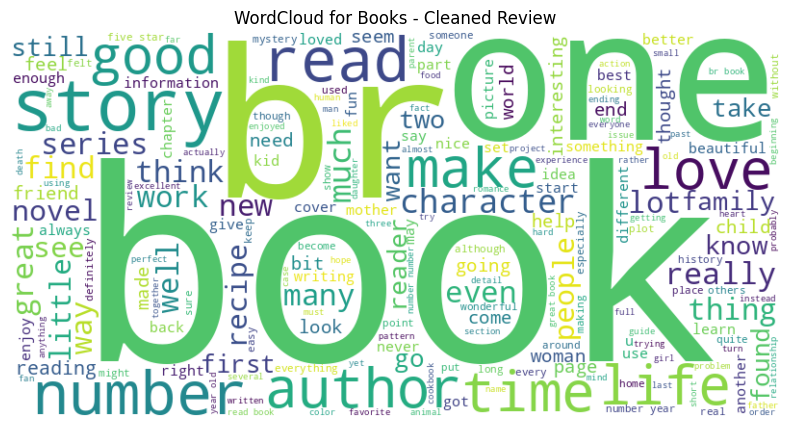

Top tokens in cleaned review:
[('book', 6127), ('br', 3731), ('number', 2104), ('one', 1800), ('read', 1766), ('story', 1731), ('like', 1380), ('would', 1208), ('good', 1160), ('great', 1075), ('love', 1059), ('time', 1016), ('character', 902), ('really', 872), ('also', 855), ('make', 848), ('life', 830), ('get', 826), ('author', 822), ('well', 817)]


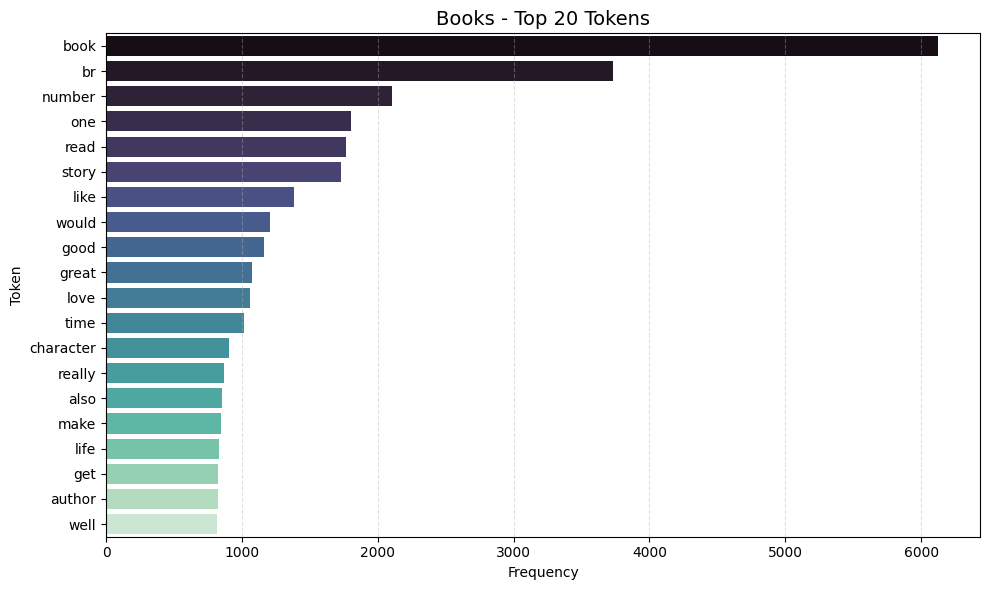

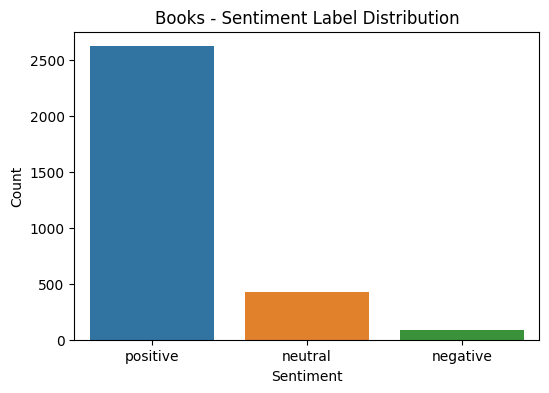

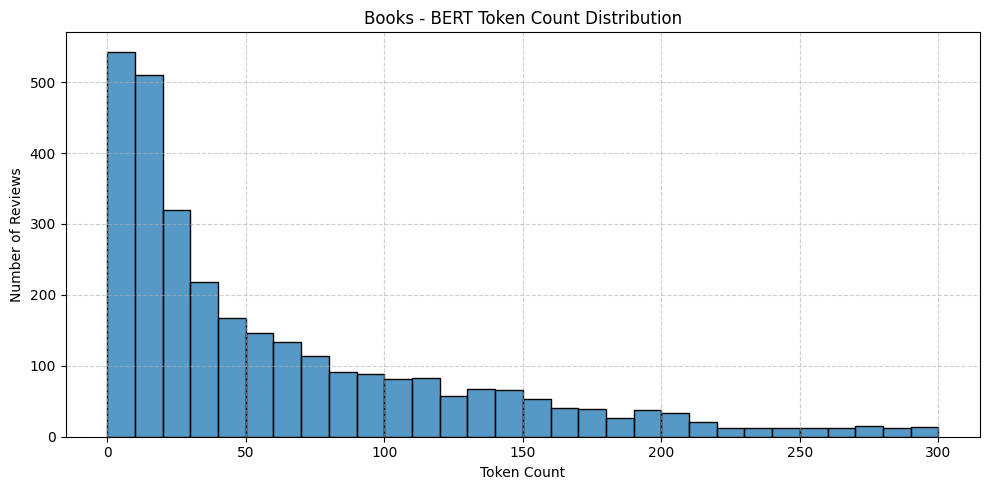

In [11]:
# Store max length of tokens per text for every category
bert_max_lens = {}

for category, _, _ in datasets_info:
    print(f"\n--- Processing category: {category} ---")

    try:
        # Load data
        df = pd.read_csv(f"{category}_cleaned.csv")

        # Convert ratings to sentiment
        def make_sentiment_label(r):
            if r >= 4: return "positive"
            elif r < 2: return "negative"
            else: return "neutral"

        df['sentiment'] = df['rating'].apply(make_sentiment_label)
        df['cleaned_review'] = df['cleaned_title'] + " " + df['cleaned_text']
        df = df[['cleaned_review', 'sentiment']].drop_duplicates()
        df = df.dropna(subset=['cleaned_review'])

        # WordCloud
        def plot_wordcloud(text, title, save_path=None):
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f"WordCloud for {title}")
            if save_path:
                plt.savefig(save_path)
            plt.show()

        plot_wordcloud(df['cleaned_review'], f"{category} - Cleaned Review")

        # Token Frequency
        def get_token_freq(column):
            tokens = [word for text in column.dropna() for word in word_tokenize(text.lower())]
            return Counter(tokens).most_common(20)

        print("Top tokens in cleaned review:")
        top_tokens = get_token_freq(df['cleaned_review'])
        print(top_tokens)

        # Horizontal bar plot 
        tokens, freqs = zip(*top_tokens)
        
        plt.style.use("default")
        plt.figure(figsize=(10, 6))
        sns.barplot(x=list(freqs), y=list(tokens), palette='mako')
        
        plt.title(f"{category} - Top 20 Tokens", fontsize=14)
        plt.xlabel("Frequency")
        plt.ylabel("Token")
        plt.grid(axis='x', linestyle='--', alpha=0.4)
        
        plt.tight_layout()
        plt.show()

        # Sentiment (Label) Distribution
        plt.figure(figsize=(6, 4))
        sns.countplot(data=df, x='sentiment', order=df['sentiment'].value_counts().index)
        plt.title(f"{category} - Sentiment Label Distribution")
        plt.xlabel("Sentiment")
        plt.ylabel("Count")
        plt.show()

        # BERT Token Stats
        token_counts = [len(word_tokenize(text)) for text in df['cleaned_review']]
        mean_tokens = np.mean(token_counts)
        std_tokens = np.std(token_counts)
        variance_tokens = np.var(token_counts)

        suggested_max_len = int(mean_tokens + 2 * std_tokens)
        bert_max_len = min(suggested_max_len, 512)

        bert_max_lens[category] = bert_max_len
        
        max_display_tokens = 300
        filtered_token_counts = [count for count in token_counts if count <= max_display_tokens]
        
        # Plot the histogram
        plt.figure(figsize=(10, 5))
        sns.histplot(filtered_token_counts, bins=range(0, max_display_tokens + 10, 10), kde=False)
        plt.title(f"{category} - BERT Token Count Distribution")
        plt.xlabel("Token Count")
        plt.ylabel("Number of Reviews")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing {category}: {e}")

In [12]:
# Map the sentiment labels to integers for BERT
label_to_id = {'negative': 0, 'neutral': 1, 'positive': 2}
id_to_label = {v:k for k,v in label_to_id.items()}

# SentimentDataset for BERT
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),        # tensor shape [max_len]
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Sets are unbalanced so we should find the best model according to f1 score
def train_bert_model(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=10, patience=2):
    best_f1 = 0
    counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} — Loss: {avg_loss:.4f}")

        _, _, f1, _ = evaluate_bert_model(model, val_loader, device)
        print(f"Validation F1: {f1:.4f}")

        # Early stopping check
        if f1 > best_f1:
            best_f1 = f1
            counter = 0
            best_model_state = model.state_dict()
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

    # Load best model
    model.load_state_dict(best_model_state)

def evaluate_bert_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro'
    )
    accuracy = accuracy_score(all_labels, all_preds)
    return precision, recall, f1, accuracy

In [13]:
for category, _, _ in datasets_info:

    # Load data
    df = pd.read_csv(f"{category}_cleaned.csv")

    # Convert ratings to sentiment
    def make_sentiment_label(r):
        if r >= 4: return "positive"
        elif r < 2: return "negative"
        else: return "neutral"

    # Get cleaned review (X) data and sentiment label (y)
    df['sentiment'] = df['rating'].apply(make_sentiment_label)
    df['cleaned_review'] = df['cleaned_title'] + " " + df['cleaned_text']
    df = df[['cleaned_review', 'sentiment']].drop_duplicates()
    df = df.dropna(subset=['cleaned_review'])

    # split the data we have ensuring similar distribution between train and test datasets
    train_df, test_df = train_test_split(
        df,
        test_size=0.2,
        stratify=df['sentiment'],
        random_state=42
    )

    # TF-IDF: Keep up to the 10,000 most frequent terms, excluding English stopwords,
    # and ignoring terms that appear in fewer than 10 documents or in more than 75% of documents.
    tfidf = TfidfVectorizer(max_features=10000, stop_words='english', min_df=10, max_df=0.75)
    tfidf_train = tfidf.fit_transform(train_df['cleaned_review'])
    tfidf_test  = tfidf.transform(test_df['cleaned_review'])
    
    w2v_train = np.vstack(train_df['cleaned_review'].apply(lambda t: vectorize_text(t, word2vec_model)).values)
    w2v_test  = np.vstack(test_df['cleaned_review'].apply(lambda t: vectorize_text(t, word2vec_model)).values)

    models = {
        ('NB', 'TFIDF'): MultinomialNB(),  # Use MultinomialNB only with TFIDF
        ('NB', 'W2V'): GaussianNB(),       # Use GaussianNB only with W2V
        ('KNN', 'TFIDF'): KNeighborsClassifier(n_neighbors=5),
        ('KNN', 'W2V'): KNeighborsClassifier(n_neighbors=5),
        ('RF', 'TFIDF'): RandomForestClassifier(n_estimators=100, random_state=42),
        ('RF', 'W2V'): RandomForestClassifier(n_estimators=100, random_state=42),
    }

    # 10 fold cross validation
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # metrics
    scoring = ['precision_macro', 'recall_macro', 'f1_macro', 'accuracy']
    
    feature_sets_train = {'TFIDF': tfidf_train, 'W2V': w2v_train}
    feature_sets_test  = {'TFIDF': tfidf_test,  'W2V': w2v_test}

    # ------- MATRIX 1: 10-Fold CV on TRAIN SET -------
    results = {}
    for (name, feat_name), clf in models.items():
        # Apply cross validation in each of the defined models
        X = feature_sets_train[feat_name]
        if isinstance(clf, GaussianNB) and hasattr(X, "toarray"):
            X = X.toarray()
        cv_res = cross_validate(clf, X, train_df['sentiment'],
                                cv=cv, scoring=scoring)
        results[(name, feat_name)] = { m: np.mean(cv_res[f'test_{m}'])
                                       for m in scoring }
    
    cv_df = pd.DataFrame.from_dict(results, orient='index')
    cv_df.index = pd.MultiIndex.from_tuples(cv_df.index,
                                            names=['Model','Features'])
    cv_df_flat = cv_df.reset_index()[['Model','Features',
                                      'precision_macro','recall_macro','f1_macro','accuracy']]
    print("\n=== 10‑Fold CV on Train Set ===")
    display(cv_df_flat.style.hide(axis='index'))

    # ------- MATRIX 1: 10-Fold CV on TRAIN SET -------
    test_results = {}
    for (name, feat_name), clf in models.items():
        # Evaluate each defined model in test set
        X_train = feature_sets_train[feat_name]
        X_test  = feature_sets_test[feat_name]
        if isinstance(clf, GaussianNB) and hasattr(X_train, "toarray"):
            X_train = X_train.toarray()
            X_test  = X_test.toarray()
        clf.fit(X_train, train_df['sentiment'])
        preds = clf.predict(X_test)
        p, r, f1, _ = precision_recall_fscore_support(
            test_df['sentiment'], preds, average='macro'
        )
        acc = accuracy_score(test_df['sentiment'], preds)
        test_results[(name, feat_name)] = {
            'precision_macro': p,
            'recall_macro':    r,
            'f1_macro':        f1,
            'accuracy':        acc
        }
    
    test_df_results = pd.DataFrame.from_dict(test_results, orient='index')
    test_df_results.index = pd.MultiIndex.from_tuples(
        test_df_results.index, names=['Model','Features']
    )
    test_df_results = test_df_results.reset_index()

    # ------ BERT MODEL | Train & Test ------
    # In BERT transformer we so not do cross validation because it does not need a lot of epochs to get trained and it gets easily overfitted
    
    # Bert pretrained tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    # Bert transformer model
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased', 
        num_labels=3  # negative | neutral | positive
    )
    
    # For BERT we do not use cross validation, but we split the train_df into train and validation
    # to perform hold-out method. Train on test set and validate on validation set keeping the
    # model which suits best for us. In this situation the datasets are unbalanced so we want to
    # balance the precision with the recall which means we use f1 score
    bert_train_df, val_df = train_test_split(
        train_df,
        test_size=0.1,
        stratify=train_df['sentiment'],
        random_state=42
    )
    
    # Create datasets
    train_dataset = SentimentDataset(bert_train_df['cleaned_review'].values, bert_train_df['sentiment'].map(label_to_id).values, tokenizer, bert_max_lens[category])
    val_dataset   = SentimentDataset(val_df['cleaned_review'].values, val_df['sentiment'].map(label_to_id).values, tokenizer, bert_max_lens[category])
    test_dataset  = SentimentDataset(test_df['cleaned_review'].values, test_df['sentiment'].map(label_to_id).values, tokenizer, bert_max_lens[category])
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=32)
    test_loader  = DataLoader(test_dataset, batch_size=32)


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Train
    train_bert_model(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=10, patience=2)
    
    # Evaluate
    precision, recall, f1, accuracy = evaluate_bert_model(model, test_loader, device)
    
    # Create a DataFrame for BERT results
    bert_df = pd.DataFrame({
        'Model': ['BERT'],
        'Features': [''],
        'precision_macro': [precision],
        'recall_macro': [recall],
        'f1_macro': [f1],
        'accuracy': [accuracy]
    })
    
    # Combine all results
    final_test_results_df = pd.concat([test_df_results, bert_df], ignore_index=True)
    print("\n=== Final Test Set Evaluation ===")
    display(final_test_results_df.style.hide(axis='index'))


=== 10‑Fold CV on Train Set ===


Model,Features,precision_macro,recall_macro,f1_macro,accuracy
NB,TFIDF,0.278353,0.333333,0.303372,0.835060
NB,W2V,0.407388,0.484750,0.326904,0.422709
KNN,TFIDF,0.430175,0.349226,0.334930,0.835857
KNN,W2V,0.478893,0.426055,0.440879,0.821514
RF,TFIDF,0.451032,0.355922,0.348545,0.836653
RF,W2V,0.329226,0.337095,0.311079,0.836255


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 — Loss: 0.5293
Validation F1: 0.3527
Epoch 2/10 — Loss: 0.3698
Validation F1: 0.4248
Epoch 3/10 — Loss: 0.2314
Validation F1: 0.4414
Epoch 4/10 — Loss: 0.1235
Validation F1: 0.4940
Epoch 5/10 — Loss: 0.0675
Validation F1: 0.5202
Epoch 6/10 — Loss: 0.0298
Validation F1: 0.4256
Epoch 7/10 — Loss: 0.0489
Validation F1: 0.4987
Early stopping triggered.

=== Final Test Set Evaluation ===


Model,Features,precision_macro,recall_macro,f1_macro,accuracy
NB,TFIDF,0.278662,0.333333,0.303556,0.835987
NB,W2V,0.406963,0.487283,0.321660,0.417197
KNN,TFIDF,0.587771,0.370190,0.370797,0.842357
KNN,W2V,0.373100,0.366013,0.365143,0.802548
RF,TFIDF,0.467361,0.352306,0.340822,0.842357
RF,W2V,0.390044,0.335985,0.310764,0.834395
BERT,,0.588634,0.524687,0.548583,0.859873
